## CUSTOMER SEGMENTATION USING UNSUPERVISED ML APPROACH

In [0]:
# 1.1 Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
import psycopg2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [0]:
INPUT_FILENAME = 'traveltide_final_features.csv'

# Load the data directly from the CSV file saved in the previous step.
# If the file is not found, a built-in FileNotFoundError will stop the script.
eda_filtered_users_pd = pd.read_csv(INPUT_FILENAME)

print(f"Data successfully loaded from '{INPUT_FILENAME}'. Shape: {eda_filtered_users_pd.shape}")



Data successfully loaded from 'traveltide_final_features.csv'. Shape: (5998, 34)


In [0]:
eda_filtered_users_pd.head()
eda_filtered_users_pd.describe()
eda_filtered_users_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    5998 non-null   int64  
 1   total_sessions             5998 non-null   int64  
 2   total_page_clicks          5998 non-null   int64  
 3   avg_page_clicks            5998 non-null   float64
 4   total_flights_booked       5998 non-null   int64  
 5   total_hotels_booked        5998 non-null   int64  
 6   total_cancellations        5998 non-null   int64  
 7   total_joint_bookings       5998 non-null   int64  
 8   trips_with_data            5998 non-null   int64  
 9   avg_flight_discount_usd    4670 non-null   float64
 10  avg_hotel_discount_usd     4006 non-null   float64
 11  avg_flight_fare_usd        5170 non-null   float64
 12  avg_seats                  5170 non-null   float64
 13  avg_checked_bags           5170 non-null   float

We will now choose 5 of the most valuable columns (and drop the rest) and create a new dataset to prepare for Unsupervised ML. 

In [0]:
customers = eda_filtered_users_pd[['user_age', 'avg_flight_fare_usd' , 'avg_hotel_total_spend_usd', 'has_children','traveller_type', 'spend_segment']]
print("Customers DataFrame now contains only the selected columns:")
display(customers.head())

Customers DataFrame now contains only the selected columns:


user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children,traveller_type,spend_segment
53,432.045,155.0,false,Leisure,Budget
53,189.91,938.0,true,Family,Mid-Range
45,248.532,621.8,false,Leisure,Mid-Range
39,367.83,639.0,false,Leisure,Mid-Range
48,93.62,642.0,true,Family,Mid-Range


We check and treat missing values

In [0]:
print("Missing values in each column:")
display(customers.isnull().sum())

Missing values in each column:


user_age                       0
avg_flight_fare_usd          828
avg_hotel_total_spend_usd    606
has_children                   0
traveller_type                 0
spend_segment                  0
dtype: int64

In [0]:
customers = customers.fillna(0)
display(customers.isnull().sum().sum())

np.int64(0)

We encode our categorical data

In [0]:

categorical_cols = ['has_children', 'traveller_type', 'spend_segment']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(customers[categorical_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=customers.index)
customers_encoded = pd.concat([customers.drop(columns=categorical_cols), encoded_df], axis=1)
customers = customers_encoded
display(customers.head())

user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium
53,432.045,155.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
53,189.91,938.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
45,248.532,621.8,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
39,367.83,639.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
48,93.62,642.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


We view summary statistics to check if we need scaling and treatment of outliers

In [0]:
print("Descriptive statistics for the current customers DataFrame:")
customers.describe()

Descriptive statistics for the current customers DataFrame:


,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium
count,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000
mean,43.255418,454.732196,755.860714,0.673558,0.326442,0.002167,0.326109,0.671724,0.211404,0.488163,0.300433
std,12.058599,671.945593,727.214162,0.468950,0.468950,0.046509,0.468827,0.469625,0.408338,0.499902,0.458485
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,209.487500,338.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44.000000,356.573333,590.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,51.000000,523.626250,958.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,90.000000,14280.380000,9015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We treat outliers first

In [0]:
initial_rows = len(customers)

# Define columns to consider for outlier removal (all numerical columns in this case)
columns_to_consider = customers.columns.tolist()

# Calculate lower and upper bounds using the IQR method for each column
lower_bounds = {}
upper_bounds = {}
for column in columns_to_consider:
    Q1 = customers[column].quantile(0.25)
    Q3 = customers[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bounds[column] = Q1 - 1.5 * IQR
    upper_bounds[column] = Q3 + 1.5 * IQR

# Initialize a boolean mask to True for all rows
outlier_mask = pd.Series(True, index=customers.index)

# Iterate through each column and update the mask
for column in columns_to_consider:
    lower = lower_bounds[column]
    upper = upper_bounds[column]
    outlier_mask = outlier_mask & \
                   (customers[column] >= lower) & \
                   (customers[column] <= upper)

# Filter the DataFrame using the final mask
customers = customers[outlier_mask]

removed_rows = initial_rows - len(customers)

print(f"Initial number of rows: {initial_rows}")
print(f"Number of rows after outlier removal: {len(customers)}")
print(f"Number of rows removed: {removed_rows}")

Initial number of rows: 5998
Number of rows after outlier removal: 3984
Number of rows removed: 2014


We scale our data 

In [0]:
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers)
customers_scaled

array([[ 0.85287194, -0.69387182,  0.52505893, ...,  0.        ,
         0.67656393, -0.67656393],
       [ 0.17821173, -0.45680863, -0.18841249, ...,  0.        ,
         0.67656393, -0.67656393],
       [-0.32778343,  0.02562398, -0.14960254, ...,  0.        ,
         0.67656393, -0.67656393],
       ...,
       [ 0.68420689,  0.85756122, -1.34323436, ...,  0.        ,
         0.67656393, -0.67656393],
       [ 0.26254426,  0.88277512,  0.65141693, ...,  0.        ,
         0.67656393, -0.67656393],
       [-1.5084388 , -1.46185433, -1.59143758, ...,  0.        ,
        -1.47805693,  1.47805693]])

In [0]:
customers_scaled = pd.DataFrame(customers_scaled)
customers_scaled.index = customers.index
customers_scaled.columns = customers.columns
customers_scaled

,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium
1,0.852872,-0.693872,0.525059,-1.436057,1.436057,0.0,1.436057,-1.436057,0.0,0.676564,-0.676564
2,0.178212,-0.456809,-0.188412,0.696351,-0.696351,0.0,-0.696351,0.696351,0.0,0.676564,-0.676564
3,-0.327783,0.025624,-0.149603,0.696351,-0.696351,0.0,-0.696351,0.696351,0.0,0.676564,-0.676564
4,0.431209,-1.083262,-0.142833,-1.436057,1.436057,0.0,1.436057,-1.436057,0.0,0.676564,-0.676564
8,-1.002444,0.781010,-0.042800,0.696351,-0.696351,0.0,-0.696351,0.696351,0.0,0.676564,-0.676564
...,...,...,...,...,...,...,...,...,...,...,...
5990,0.346877,-0.180556,-0.007450,0.696351,-0.696351,0.0,-0.696351,0.696351,0.0,0.676564,-0.676564
5991,0.599874,-1.022158,-0.174423,0.696351,-0.696351,0.0,-0.696351,0.696351,0.0,0.676564,-0.676564
5992,0.684207,0.857561,-1.343234,-1.436057,1.436057,0.0,1.436057,-1.436057,0.0,0.676564,-0.676564
5996,0.262544,0.882775,0.651417,-1.436057,1.436057,0.0,1.436057,-1.436057,0.0,0.676564,-0.676564



We now check for `n_components` to decide how many features (or columns) we should keep after reducing the data's size. The goal is to keep most of the important information while making the data simpler and easier to work with.

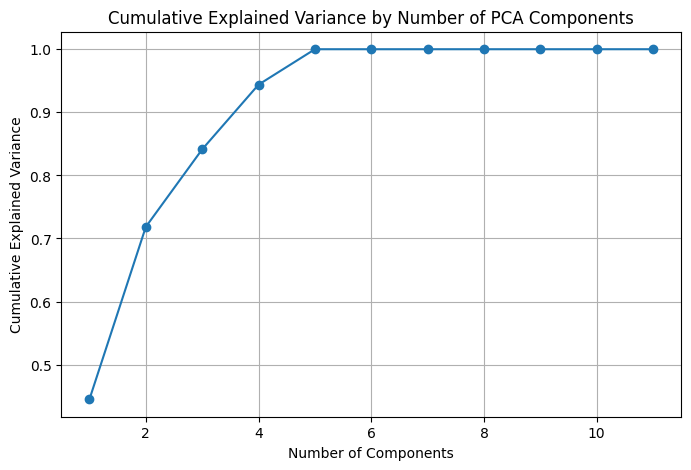

Component,Explained Variance,Cumulative Variance
1,0.4452457903331682,0.4452457903331682
2,0.27320241255642813,0.7184482028895963
3,0.12286596863746917,0.8413141715270654
4,0.10256730351751792,0.9438814750445834
5,0.05611852495541664,1.0
6,3.726690814916999E-17,1.0
7,1.2805479096295211E-18,1.0
8,8.605172774826614E-34,1.0
9,7.854446695716782E-66,1.0
10,0.0,1.0


In [0]:
pca = PCA()
pca.fit(customers_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

display(pd.DataFrame({
    'Component': range(1, len(explained_variance) + 1),
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
}))


We should choose the value of `n_components` where the explained variance reaches a threshold (commonly 90-95%).Based on the output above, our **n_components = 5**

In [0]:
pca = PCA(n_components = 0.5)

customers_pca = pca.fit_transform(customers_scaled)
customers_pca

array([[ 2.84224847,  0.79619043],
       [-1.42982601,  0.53808223],
       [-1.44925253,  0.70459297],
       ...,
       [ 2.787207  ,  1.48164704],
       [ 2.7894293 ,  1.48091205],
       [ 3.00898913, -2.56296977]])

In [0]:
component_matrix = pd.DataFrame(pca.components_).T
component_matrix.columns = [f"pca_{i}"for i in range(component_matrix.shape[1])]
component_matrix.index = customers_scaled.columns
component_matrix

,pca_0,pca_1
user_age,0.010035,0.132185
avg_flight_fare_usd,-0.030033,0.482061
avg_hotel_total_spend_usd,0.003615,0.021481
has_children_False,-0.498920,-0.031406
has_children_True,0.498920,0.031406
traveller_type_Business,-0.000000,-0.000000
traveller_type_Family,0.498920,0.031406
traveller_type_Leisure,-0.498920,-0.031406
spend_segment_Budget,-0.000000,-0.000000
spend_segment_Mid-Range,-0.040616,0.610630


In [0]:
customers_pca = pd.DataFrame(customers_pca)
customers_pca.index = customers.index
customers_pca.columns = [f"pca_{i}"for i in range(customers_pca.shape[1])]
customers_pca

,pca_0,pca_1
1,2.842248,0.796190
2,-1.429826,0.538082
3,-1.449253,0.704593
4,2.847297,0.538396
8,-1.478324,0.981849
...,...,...
5990,-1.435776,0.697435
5991,-1.408565,0.321587
5992,2.787207,1.481647
5996,2.789429,1.480912


We will now determine the optimal number of K

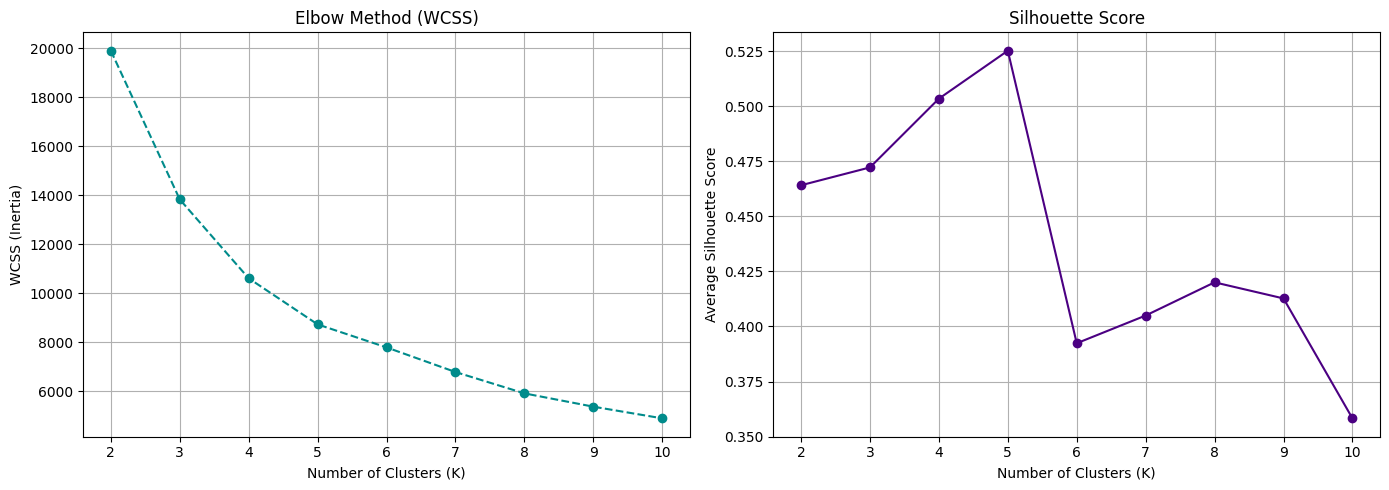


--- Silhouette Scores by K ---
    K  Silhouette Score
0   2          0.464165
1   3          0.472271
2   4          0.503508
3   5          0.525292
4   6          0.392384
5   7          0.404977
6   8          0.420062
7   9          0.412746
8  10          0.358271


In [0]:
# 5. Determine the Optimal Number of Clusters (K) 

k_range = range(2, 11)
wcss = [] 
silhouette_scores = [] 


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=1000) 
    kmeans.fit(customers_scaled)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(customers_scaled, kmeans.labels_)
    silhouette_scores.append(score)
        

# --- Plotting the K Analysis ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o', linestyle='--', color='darkcyan')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range) 
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='indigo') 
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
 
plt.tight_layout()
plt.show()

k_analysis = pd.DataFrame({'K': list(k_range), 'WCSS': wcss, 'Silhouette Score': silhouette_scores})
print("\n--- Silhouette Scores by K ---")
print(k_analysis[['K', 'Silhouette Score']])
print("=" * 50)

Based on the Silhouette Score, the optimal **K = 5**

In [0]:
kmeans = KMeans(n_clusters=5)
groups = kmeans.fit_predict(customers_pca)
groups

array([1, 0, 0, ..., 1, 1, 3], dtype=int32)

In [0]:
groups = pd.Series(groups)
groups.index = customers.index
groups.name = "group"
groups

1       1
2       0
3       0
4       1
8       4
       ..
5990    0
5991    0
5992    1
5996    1
5997    3
Name: group, Length: 3984, dtype: int32

In [0]:
pd.crosstab(groups,"count")

col_0,count
group,
0,891
1,864
2,814
3,437
4,978


<Axes: xlabel='pca_0', ylabel='pca_1'>

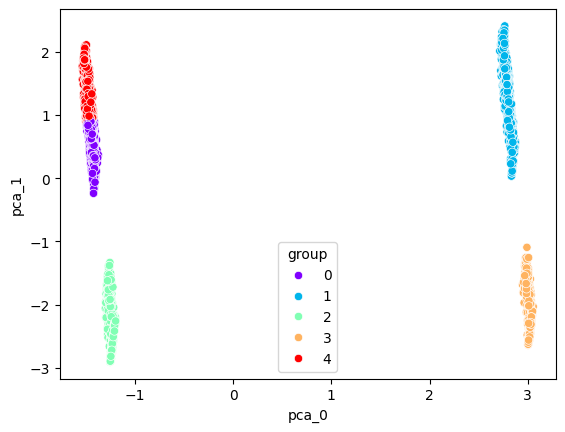

In [0]:
customers_viz = pd.concat([customers_pca,groups],axis=1)
customers_viz

# Plot visualization
sns.scatterplot(data=customers_viz,x="pca_0",y="pca_1",hue="group",palette="rainbow",legend='full')

In [0]:
customers["group"] = groups
customers

,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium,group
1,53,189.910,938.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,45,248.532,621.800000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,39,367.830,639.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,48,93.620,642.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
8,31,554.625,686.333333,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
5990,47,316.845,702.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
5991,50,108.730,628.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
5992,51,573.555,110.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
5996,46,579.790,994.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1


In [0]:
customers.loc[customers["group"]==0,:]

,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium,group
2,45,248.532000,621.800000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,39,367.830000,639.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
17,45,296.403333,671.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
28,53,383.517500,575.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
29,41,49.870000,805.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5965,40,321.258333,528.500000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
5977,28,508.456667,217.666667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
5988,39,329.790000,505.500000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
5990,47,316.845000,702.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


Characteristics of Group 0 : Travelling without Children, Traveller_type is Leisure, and Spend Segment is mid-range.

In [0]:
customers.loc[customers["group"]==1,:]

,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium,group
1,53,189.910000,938.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,48,93.620000,642.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
10,56,414.190000,518.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
12,42,916.116667,1156.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
21,61,642.020000,337.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5982,49,432.760000,552.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
5983,54,789.480000,118.500000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
5987,37,293.790000,652.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
5992,51,573.555000,110.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1


Characteristics of Group 1 : Travelling with children, Traveller-Type is family and Spend Segment is mid-range

In [0]:
customers.loc[customers["group"]==2,:]

,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium,group
9,21,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
15,21,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
22,47,436.510000,1263.500000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
51,29,199.470000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
64,52,413.566667,1123.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5956,33,332.486667,1505.333333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
5957,23,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
5978,45,344.350000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2
5981,22,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2


Characteristics of Group 2 : Travelling with children, Traveller-Type is family and Spend Segment is premium.

In [0]:
customers.loc[customers["group"]==3,:]

,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium,group
1,53,189.910000,938.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
4,48,93.620000,642.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
10,56,414.190000,518.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
12,42,916.116667,1156.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
21,61,642.020000,337.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
5982,49,432.760000,552.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
5983,54,789.480000,118.500000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
5987,37,293.790000,652.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3
5992,51,573.555000,110.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3


Group 3 seems to have same characteristics as Group 0

In [0]:
customers.loc[customers["group"]==4,:]

,user_age,avg_flight_fare_usd,avg_hotel_total_spend_usd,has_children_False,has_children_True,traveller_type_Business,traveller_type_Family,traveller_type_Leisure,spend_segment_Budget,spend_segment_Mid-Range,spend_segment_Premium,group
8,31,554.625000,686.333333,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
18,36,509.210000,738.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
19,19,928.420000,386.500000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
23,42,685.158571,540.166667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
30,57,976.760000,852.500000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
5924,35,624.680000,204.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
5928,67,518.950000,1094.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
5951,32,608.192500,626.250000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4
5962,60,506.965000,487.500000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4


Characteristics of Group 4 : Travelling without children, Traveller-Type is leisure and Spend Segment is mid_range.

As observed, the ML approach does not provide clear customer segmentation for this dataset, as some groups have overlapping characteristics. Therefore, we will proceed with a manual approach.